In [25]:
import torch
from torchvision import models
from torch.nn import Sequential
from torch import nn
import pickle

device = "mps"
# Define the VGG19 model architecture
vgg19_model = models.vgg19(pretrained=False)

# Load the model state_dict onto MPS device
model_path = 'model.pth'
state_dict = torch.load(model_path, map_location=device)


/Users/trHien/miniforge3/envs/PL310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/trHien/miniforge3/envs/PL310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/7d/kw777g6x067glyytqm78n7lr0000gn/T/ipykernel_10296/2201598926.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 

In [26]:
# override last layers
num_classes = 5
vgg19_model.classifier[6] = nn.Linear(vgg19_model.classifier[6].in_features, num_classes)
vgg19_model = vgg19_model.to(device=device)

vgg19_model.load_state_dict(state_dict)
vgg19_model.eval()  # Set model to evaluation mode

# Create a feature extractor from the model's features
feature_extractor = Sequential(*list(vgg19_model.features.children())).to(device) 

In [27]:
vgg19_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [28]:
feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [29]:
from torchvision import transforms
from PIL import Image
from PIL import UnidentifiedImageError
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def remove_duplicates(similar, feature_extractor,threshold=1e-6):
    image_features = []
    image_paths = []
    sim_scores = []
    for i in similar:
        a, sim_score = i
        feature = extract_features(a,feature_extractor, device="mps")
        image_features.append(feature)
        image_paths.append(a)
        sim_scores.append(sim_score)
        
    image_features = np.array(image_features)
    dup = {}
    num_images = len(image_paths)
    for i in tqdm(range(num_images)):
        if image_paths[i] in dup:  # Skip if already flagged as duplicate
            continue

        # Compare current feature with the rest
        differences = np.sum(np.abs(image_features[i] - image_features[i+1:]), axis=1)
        duplicates = np.where(differences <= threshold)[0]

        for idx in duplicates:
            dup[image_paths[i+1+idx]] = True 

    # Filter unique paths and features
    new_paths = [path for path in image_paths if path not in dup]
    new_image_features = [image_features[i] for i, path in enumerate(image_paths) if path not in dup]
    new_sim_score = [sim_scores[i] for i, path in enumerate(image_paths) if path not in dup]

    results = []
    for i,j,z in zip(new_paths, new_image_features, new_sim_score):
        results.append((i,j,z))
    return results

# Feature extraction function
def extract_features(image_path, feature_extractor, device="cpu"):
    img_tensor = None
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    except UnidentifiedImageError as e:
        # print(f"Image error: ",image_path)
        return None
    with torch.no_grad():
        features = feature_extractor(img_tensor)
    return features.flatten().cpu().numpy()  # Return features on CPU for further processing

# Function to find similar images
def find_similar_images(query_image_path, image_features, image_paths, feature_extractor, device, top_k=5):
    query_features = extract_features(query_image_path, feature_extractor, device)
    similarities = cosine_similarity([query_features], image_features)[0]
    sorted_indices = np.argsort(similarities)[::-1][1:top_k]  # Top-k similar images
    return [(image_paths[i], similarities[i]) for i in sorted_indices]


# Example usage for extracting features on MPS
query_image = "art-images-drawings-painting-sculpture-engraving/musemart/dataset_updated/training_set/drawings/167176.jpg"
features = extract_features(query_image, feature_extractor, device)
print(features.shape)


(25088,)


# Get features.npy and image_paths.pkl

In [30]:
# import os
# import numpy as np
# from tqdm import tqdm
# dataset_path = 'art-images-drawings-painting-sculpture-engraving'
# image_features = []
# image_paths = []

# # Function to extract features for a dataset
# for root, _, files in os.walk(dataset_path):  # Use os.walk for recursive traversal
#     print("Checking ",root)
#     for img_name in files:
#         img_path = os.path.join(root, img_name)
#         features = extract_features(img_path, feature_extractor, device)
#         if features is None:
#             continue
#         image_features.append(features)
#         image_paths.append(img_path)

# image_features = np.array(image_features)  # Convert to NumPy array


# Save and load file

In [31]:
# np.save("features.npy", image_features) # ! Danger Watch out
# # Save to a file
# with open('image_paths.pkl', 'wb') as file:
#     pickle.dump(image_paths, file) # ! Danger Watch out

with open('image_paths.pkl', 'rb') as file:
    image_paths = pickle.load(file)


image_features = np.load("features.npy")
image_features.shape, len(image_paths)

((12568, 25088), 12568)

In [32]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_image(image_path, title):
    # Open the image
    img = Image.open(image_path)
    
    # Plot the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.title(title)
    plt.show()


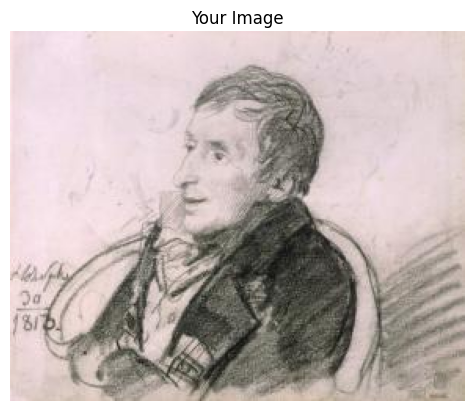

100%|██████████| 19/19 [00:00<00:00, 6513.96it/s]


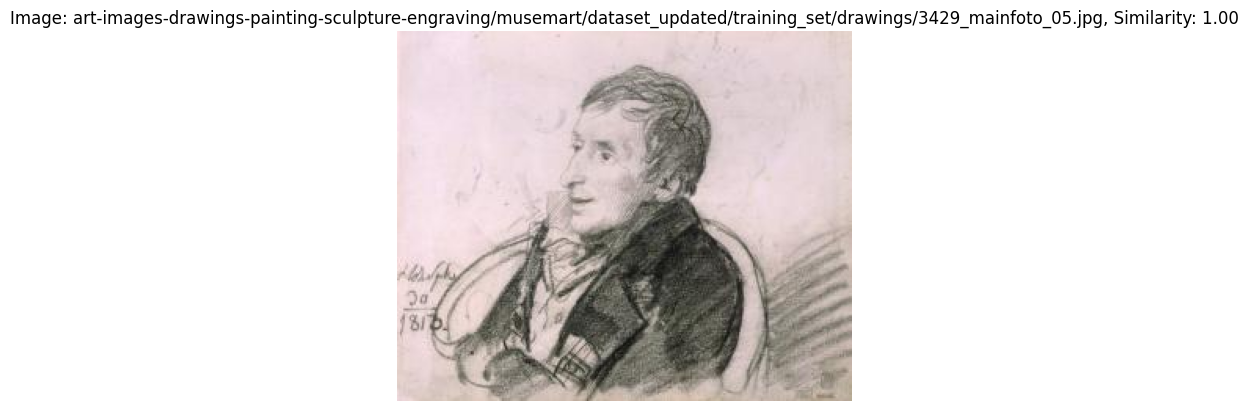

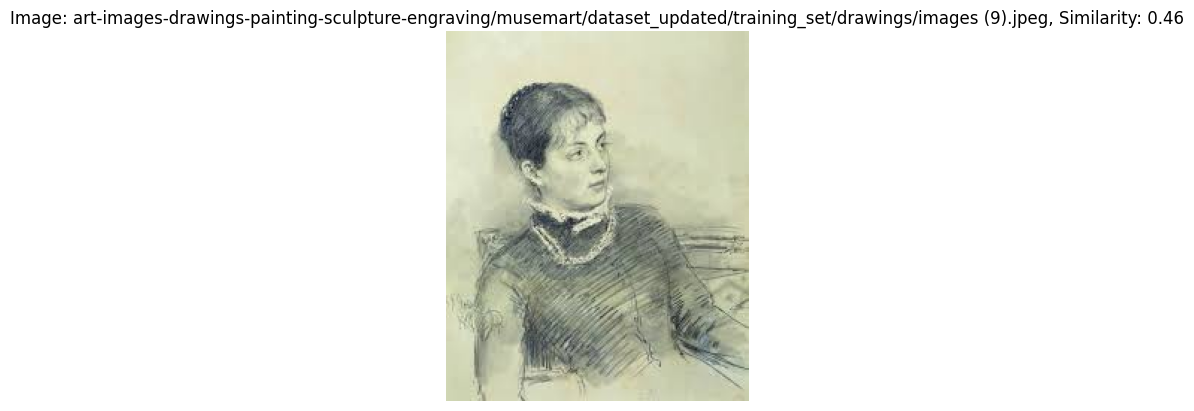

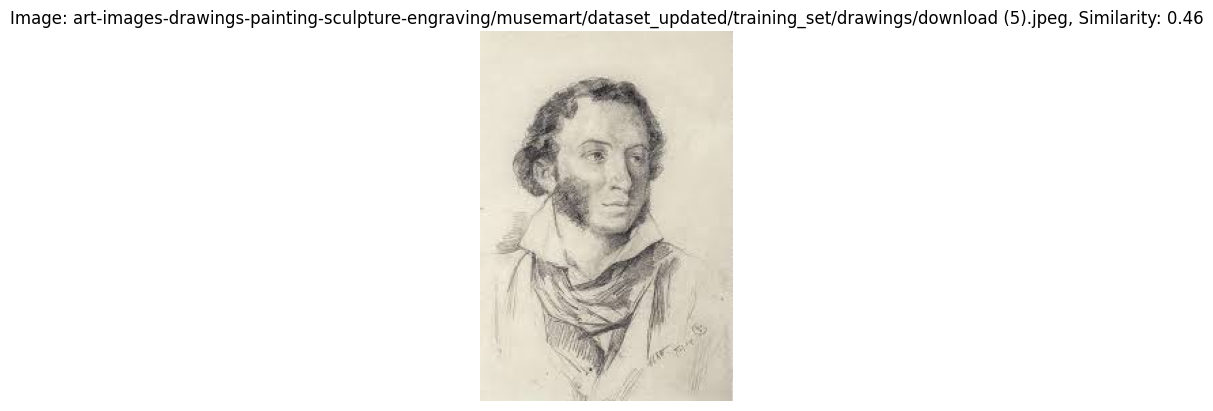

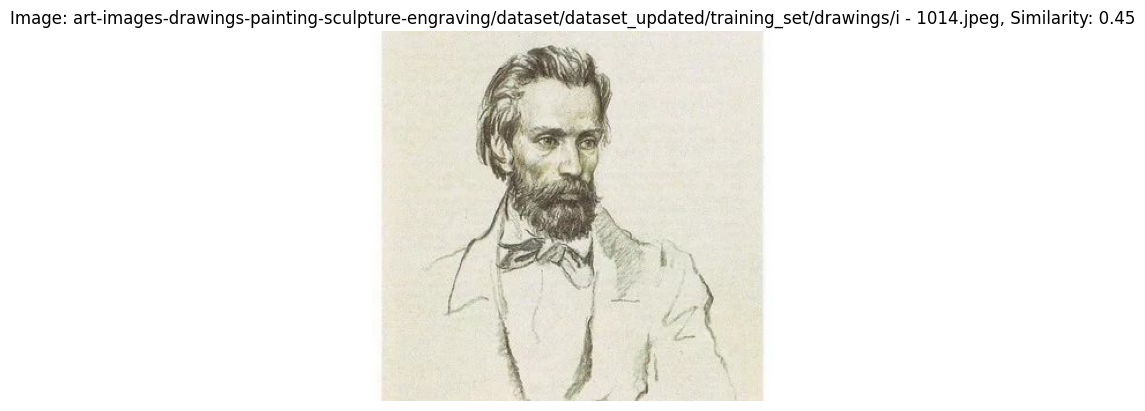

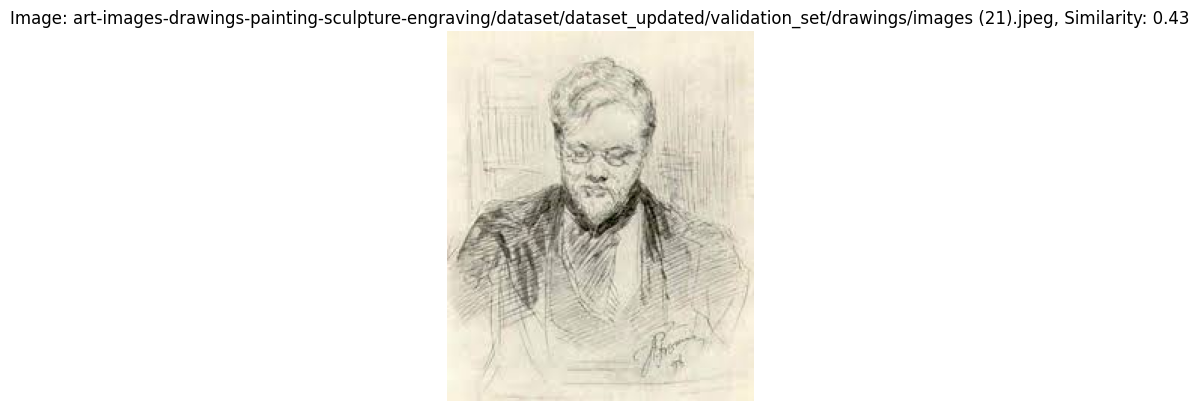

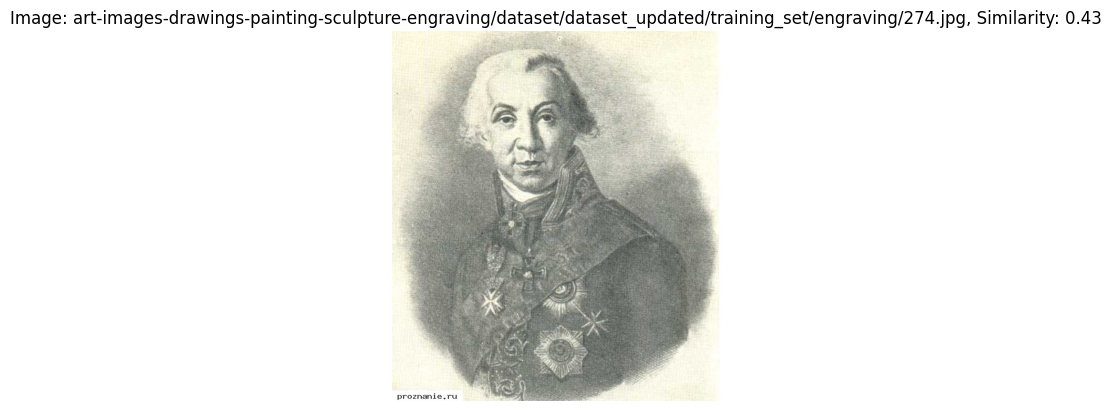

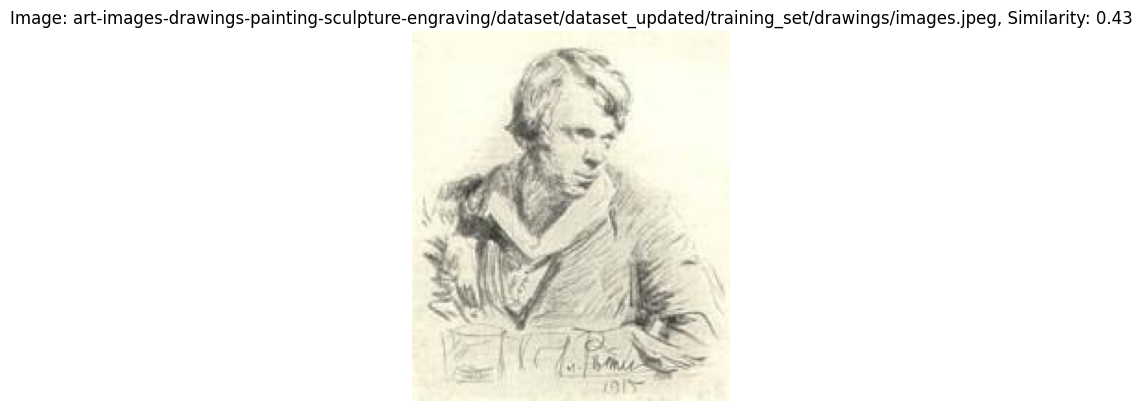

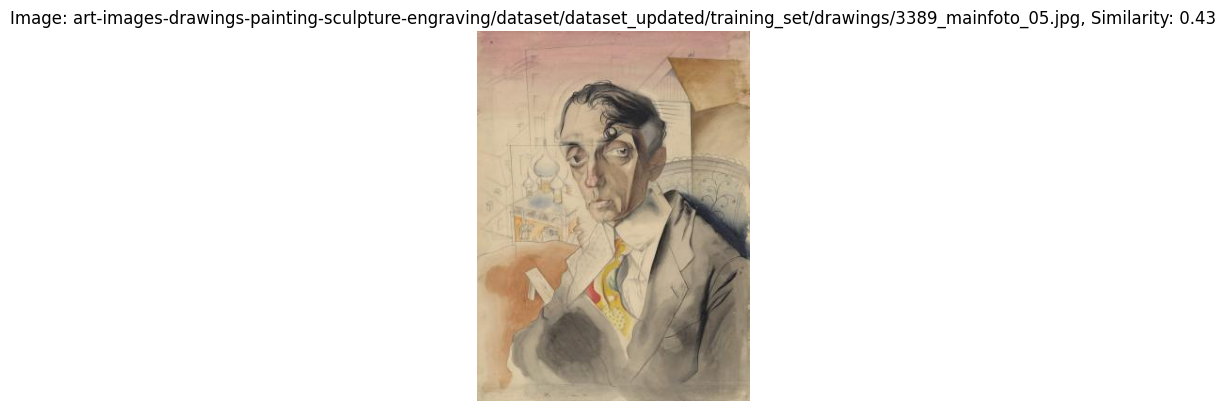

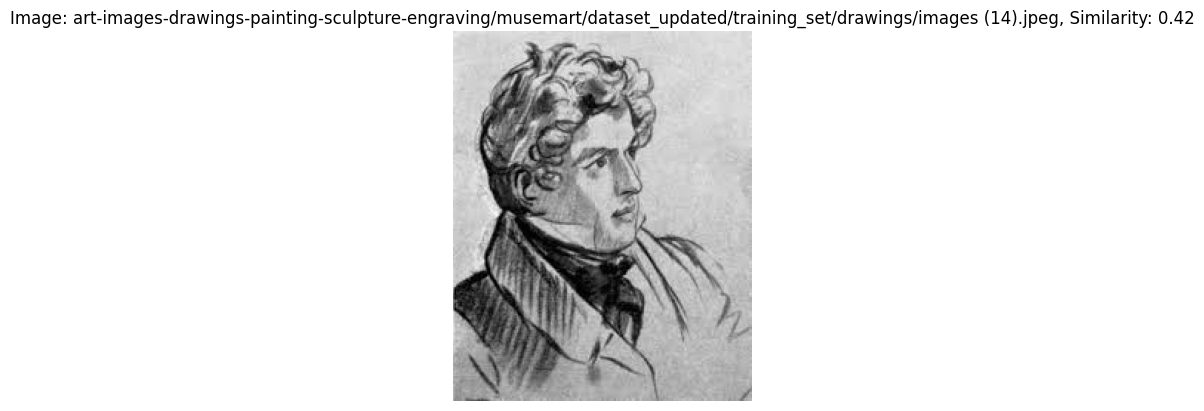

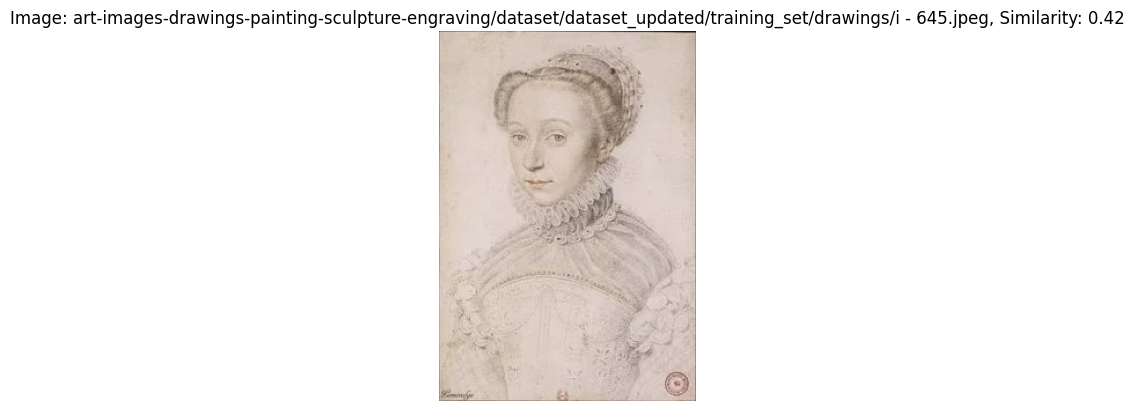

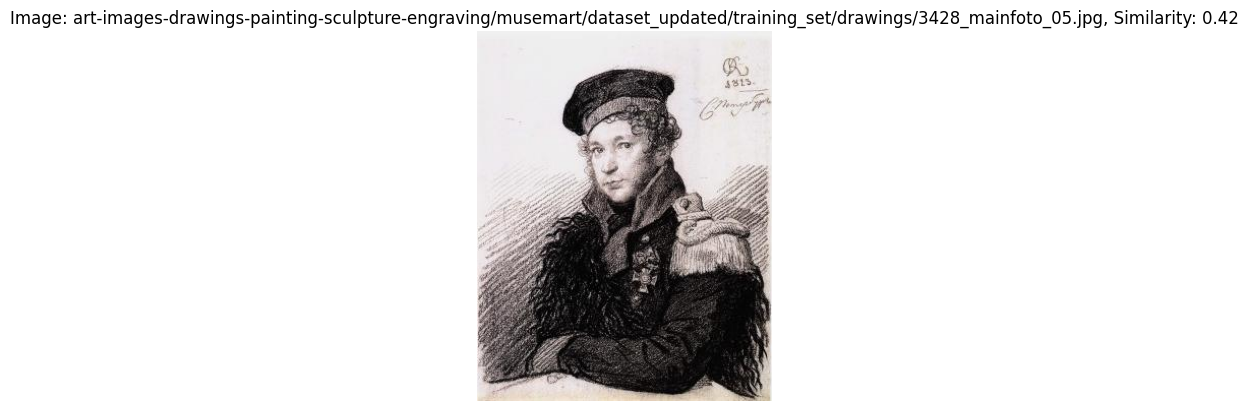

In [34]:
query_image = "art-images-drawings-painting-sculpture-engraving/musemart/dataset_updated/training_set/drawings/3429_mainfoto_05.jpg"
plot_image(image_path=query_image, title="Your Image")
similar_images = find_similar_images(query_image, image_features, image_paths, feature_extractor, device, top_k=20)
similar_images = remove_duplicates(similar_images,feature_extractor)

# Display results
for img_path,_, similarity in similar_images:
    plot_image(image_path=img_path, title=f"Image: {img_path}, Similarity: {similarity:.2f}")


# K-mean